**Overview Framework of GTP and Llama**:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/bonus/gpt-to-llama/gpt2-to-llama2-llama3.webp?1">

**Core modifications**:
- Remove dropout operations
- Replace LayerNorm with RMSNorm
- Replace GELU activation layer with SiLU or Swish activation layer, besides use additional linear layer as gate (SwiGLU)
- Replace APE(absolute position embeddings) with RoPE (rotary position embeddings)
- Some other changements: embedding dimension (1600 -> 4096), vocabulary size (50256 -> 32000), number of heads in MMHA (25 -> 32), number of repeated transformer blocks (48 -> 32), hidden layer of dimension (6400 -> 11008)

In [3]:
from importlib.metadata import version

pkgs = [
    "huggingface_hub",  # to download pretrained weights
    "sentencepiece",    # to implement the tokenizer
    "torch",            # to implement the model
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

huggingface_hub version: 0.27.0
sentencepiece version: 0.2.0
torch version: 2.2.2


### Replace LayerNorm with RMSNorm layer

Recall the LayerNorm:

$$y_i = \alpha\frac{x_i - \bar{x}}{\sigma} + \beta, \quad \text{where} \quad \bar{x} = \frac{1}{n}\sum_{i=0}^n x_i, \quad \sigma = \sqrt{\frac{1}{n}\sum_{i=1}^n (x_i - \bar{x})^2}$$

where the $\alpha$ and $\beta$ are trainable parameters.

- First, we replace LayerNorm by Root Mean Square Layer Normalization (RMSNorm)
- LayerNorm normalizes inputs using mean and variance, while RMSNorm uses only the root mean square, which improves computational efficiency
- The RMSNorm operation is as follows, where $x$ is the input $\gamma$ is a trainable parameter (vector), and $\epsilon$ is a small constant to avoid zero-division errors:

$$y_i = \frac{x_i}{\text{RMS}(x)} \gamma_i, \quad \text{where} \quad \text{RMS}(x) = \sqrt{\epsilon + \frac{1}{n} \sum x_i^2}$$

- For more details, please see the paper [Root Mean Square Layer Normalization (2019)](https://arxiv.org/abs/1910.07467)

In [8]:
import torch
import torch.nn as nn

class RMSNorm(nn.Module):
    def __init__(self, embed_dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.embed_dim = embed_dim
        self.gamma = nn.Parameter(torch.ones(embed_dim)).float()

    def forward(self, x):
        rms = x.pow(2).mean(dim=-1, keepdim=True)
        rms = x * torch.rsqrt(self.eps + rms)
        x_normed = (rms * self.gamma.to(x.device)).to(dtype=x.dtype)
        return x_normed

In [11]:
torch.manual_seed(123)

batch = torch.randn(2, 3, 4)
rms_norm = RMSNorm(embed_dim=batch.shape[-1])
rms_normed_batch = rms_norm(batch)

print("Our implementation:", rms_normed_batch)

Our implementation: tensor([[[ 0.8834, -0.4655, -0.7948, -1.5398],
         [ 0.8053,  1.5254, -0.5074, -0.8759],
         [-0.1619, -0.4049,  0.7016, -1.8214]],

        [[ 1.3348, -0.1232,  0.9638, -1.1288],
         [-0.8511, -1.5285, -0.4420,  0.8624],
         [ 0.9398,  0.2082,  1.7241, -0.3180]]], grad_fn=<MulBackward0>)


### Replace GELU with SiLU activation

Recall the GELU activation:

$$\text{gelu}(x) = \frac{1}{2}x\left[1 + \tanh{\left(x\sqrt{\frac{2}{\pi}} (x+0.044715x^3)\right)}\right] $$

- Llama uses the SiLU activation function (instead of GELU), which is also known as the Swish function:

$$
\text{silu}(x) = x \cdot \sigma(x), \quad \text{where} \quad \sigma(x) \text{ is the logistic sigmoid.}
$$

- For more information, see the SiLU paper: [Sigmoid-Weighted Linear Units for Neural Network Function Approximation in Reinforcement Learning (2017)](https://arxiv.org/abs/1702.03118)

In [12]:
class SiLU(nn.Module):
    def __init__(self):
        super(SiLU, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

In [17]:
import matplotlib.pyplot as plt

In [23]:
gelu = nn.GELU()
silu = SiLU()

x = torch.linspace(-5, 5, 100)
y_gelu, y_silu = gelu(x), silu(x)

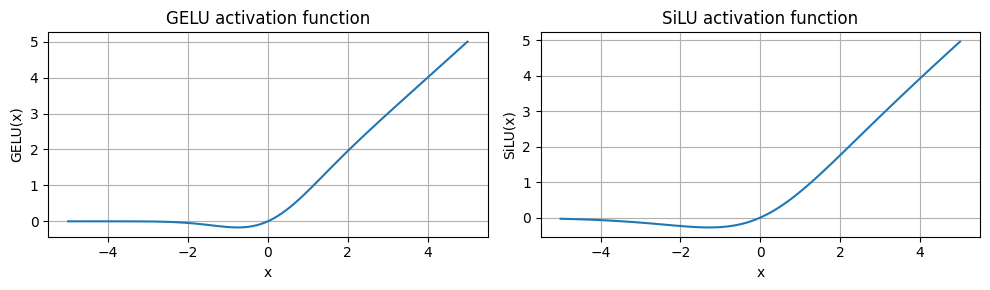

In [24]:
plt.figure(figsize=(10,3))
for i, (y, label) in enumerate(zip([y_gelu, y_silu], ["GELU", "SiLU"]), 1):
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

### Update the FeedForward module

- In fact, Llama uses a "Gates Linear Unit" (GLU) variant of SiLU called SwiGLU, which essentially results in a slightly differently structured `FeedForward` module
- SwiGLU uses a gating mechanism in the feedforward layer, with the formula:

$$\text{SwiGLU}(x) = \text{SiLU}(\text{Linear}_1(x)) * (\text{Linear}_2(x))$$

- Here, $\text{Linear}_1$ and $\text{Linear}_2$ are two linear layers, and $*$ denotes element-wise multiplication
- The third linear layer, $\text{Linear}_3$, is applied after this gated activation

- For more information, see SwiGLU paper: [GLU Variants Improve Transformer (2020)](https://arxiv.org/abs/2002.05202)

In [25]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        self.fc1 = nn.Linear(cfg['emb_dim'], cfg['hidden_dim'], dtype=cfg["dtype"], bias=False)
        self.fc2 = nn.Linear(cfg['emb_dim'], cfg['hidden_dim'], dtype=cfg["dtype"], bias=False)
        self.fc3 = nn.Linear(cfg['hidden_dim'], cfg['emb_dim'], dtype=cfg['dtype'], bias=False)

        self.silu = SiLU()

    def forward(self, x):
        return self.fc3(self.silu(self.fc1(x)) * self.fc2(x))